In [7]:
                                            #---- Data warehousing ----#
#                                                 ----------------
#-----
import pandas as pd #reading and writing csv files  
import numpy as np # dealing with arrays 
import seaborn as sns # for advanced graphs 
import matplotlib.pyplot as plt # for traditional graphs 
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint

import warnings
warnings.filterwarnings('ignore')
                                            #---- Machine learning ----#
#                                                 ----------------

# draw matplotlib graphs inline 
%matplotlib inline
sns.set_style("whitegrid") # configuration for seaborn library

In [2]:
orders = pd.read_excel('../ex_retail2_forecasting_data.xlsx', index_col=0)

In [3]:
orders.head()

,InvoiceDate,StockCode,Quantity,TotalPrice,Week,Weekday,Day,UnitPrice
0,2009-12-01,10002,12,10.20,49,1,1,0.850000
1,2009-12-01,10120,60,12.60,49,1,1,0.210000
2,2009-12-01,10125,5,5.10,49,1,1,1.020000
3,2009-12-01,10133,23,26.35,49,1,1,1.145652
4,2009-12-01,11001,2,6.86,49,1,1,3.430000


In [4]:
# Define the feature and target variables
# Split the dataset into train and test dataset

df_train = orders[orders.InvoiceDate<'2011-11-01']
df_test = orders[orders.InvoiceDate>='2011-11-01']

# Based on date and unitPrice the qunaitity will be prediceted
X_train = df_train.drop(labels=['InvoiceDate','StockCode','Quantity','TotalPrice'],axis=1)
y_train = df_train.Quantity

X_test = df_test.drop(labels=['InvoiceDate','StockCode','Quantity','TotalPrice'],axis=1)
y_test = df_test.Quantity

In [5]:
def rmse(y_actual, y_pred):
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    return rmse
rmse_cv = make_scorer(rmse, greater_is_better=False)

In [20]:
# Function to predict on train and test data and return the required metrics
def model_fit(model, X_train, y_train, X_test, y_test):
    ''' 
    Input:
        model = model to be applied
        X_train y_train = Training data
        X_test, y_test = Testing data
    Output:
        rmse for training and test data 
        predicted y for training and test data
    
    '''
    model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    rmse_train = rmse(y_train, y_train_predict)
    rmse_test = rmse(y_test, y_test_predict)
    
    rmse_all = [rmse_train, rmse_test]
    y_pred_all = [y_train_predict, y_test_predict]
    
    return(rmse_all, y_pred_all)

In [8]:

xgb_model = xgb.XGBRegressor()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

In [ ]:
xgb_model_cv = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

xgb_model_cv.fit(X_train, y_train)


In [10]:
# xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [111]:
xgb_model = xgb.XGBRegressor(gamma=0.5, learning_rate=0.8, max_depth=3, n_estimators=250, subsample=0.4)

rmse_summary, y_predict_summary = model_fit(xgb_model, X_train, y_train, X_test, y_test)

In [112]:
rmse_summary

[17.135267563947142, 20.71300836571965]

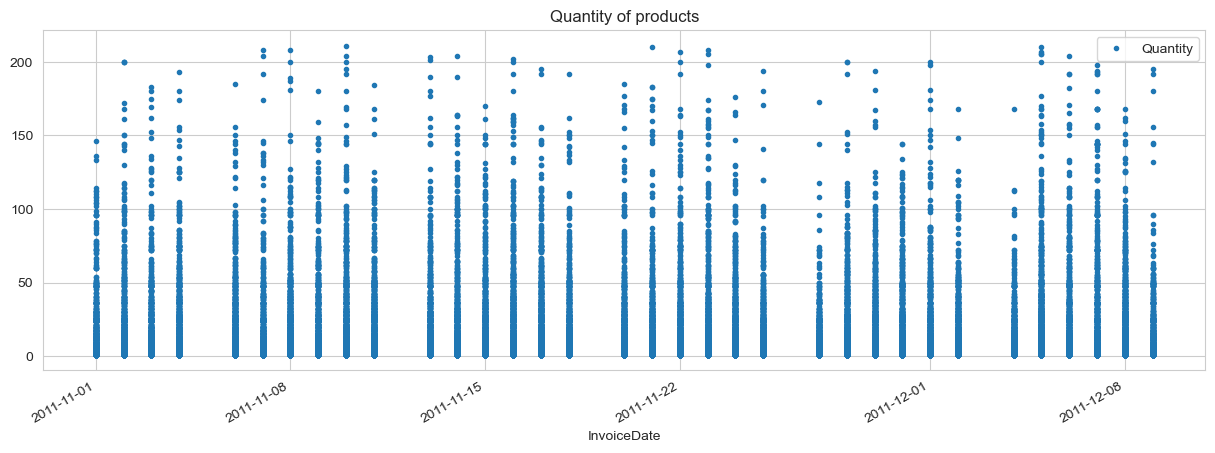

In [113]:
color_pal = sns.color_palette()
orders_df = orders[['InvoiceDate', 'Quantity']]
orders_df.index = pd.to_datetime(orders_df.index)
orders_df = orders_df.set_index('InvoiceDate')
orders_df = orders_df.loc[orders_df.index >= '2011-11-01']
orders_df.plot(style='.',
        figsize=(15, 5),
        color=color_pal,
        title='Quantity of products')
plt.show()

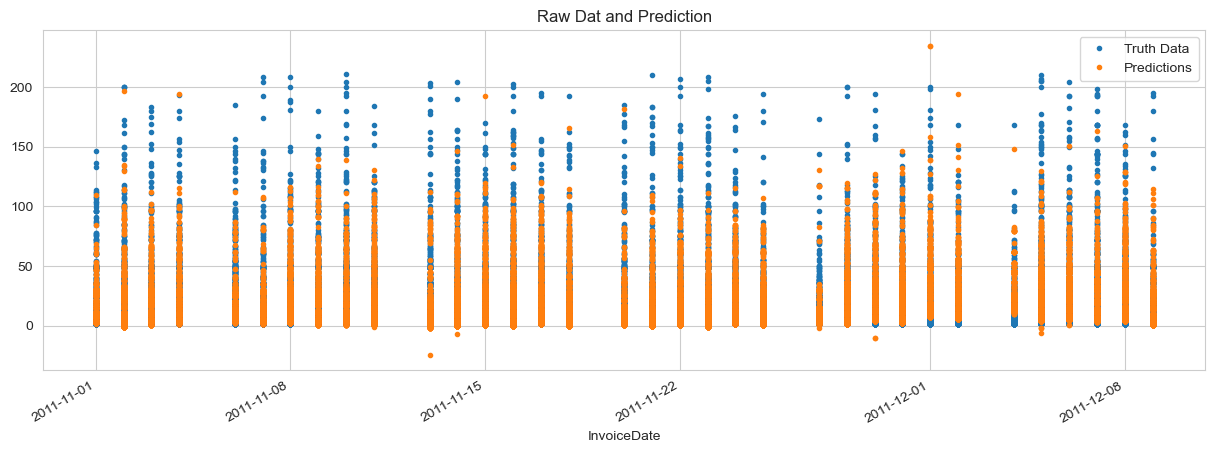

In [114]:
orders_df_pred = orders_df
orders_df_pred['prediction'] = y_predict_summary[1]
ax = orders_df[['Quantity']].plot(figsize=(15, 5), style='.')
orders_df_pred['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

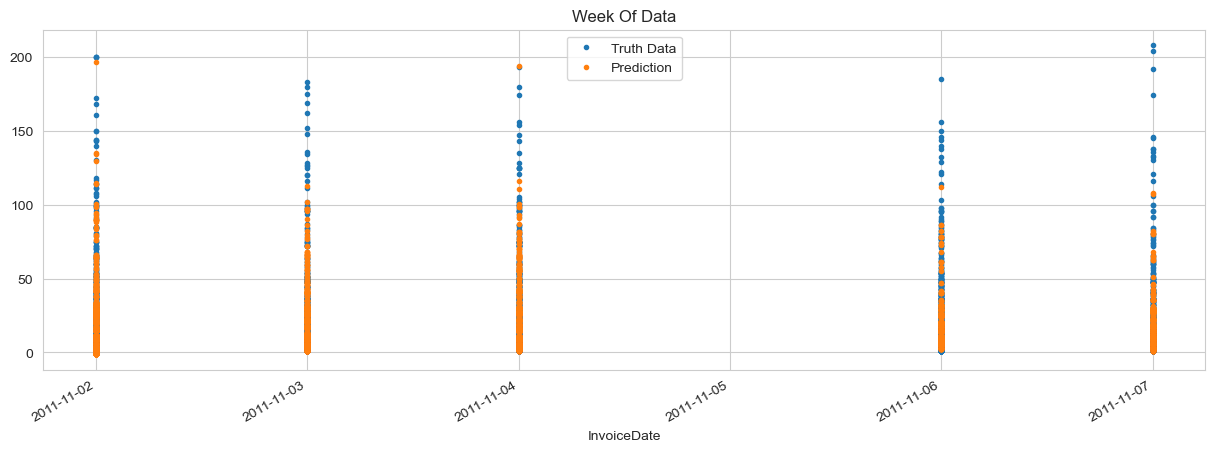

In [115]:
ax = orders_df.loc[(orders_df.index > '2011-11-01') & (orders_df.index < '2011-11-08')]['Quantity'] \
    .plot(figsize=(15, 5), title='Week Of Data', style='.')
orders_df_pred.loc[(orders_df_pred.index > '2011-11-01') & (orders_df_pred.index < '2011-11-08')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()